<a href="https://colab.research.google.com/github/catpixie-47/FDIP/blob/main/FDIP_7_123B1F047.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from collections import Counter
import math


def zigzag(block):
    indices = [
        (0,0),(0,1),(1,0),(2,0),(1,1),(0,2),(0,3),(1,2),(2,1),(3,0),
        (4,0),(3,1),(2,2),(1,3),(0,4),(0,5),(1,4),(2,3),(3,2),(4,1),
        (5,0),(6,0),(5,1),(4,2),(3,3),(2,4),(1,5),(0,6),(0,7),(1,6),
        (2,5),(3,4),(4,3),(5,2),(6,1),(7,0),(7,1),(6,2),(5,3),(4,4),
        (3,5),(2,6),(1,7),(2,7),(3,6),(4,5),(5,4),(6,3),(7,2),(7,3),
        (6,4),(5,5),(4,6),(3,7),(4,7),(5,6),(6,5),(7,4),(7,5),(6,6),
        (5,7),(6,7),(7,6),(7,7)
    ]
    return np.array([block[i,j] for i,j in indices])

# Inverse zigzag (1D → 8x8 block)
def inverse_zigzag(vector):
    block = np.zeros((8,8))
    indices = [
        (0,0),(0,1),(1,0),(2,0),(1,1),(0,2),(0,3),(1,2),(2,1),(3,0),
        (4,0),(3,1),(2,2),(1,3),(0,4),(0,5),(1,4),(2,3),(3,2),(4,1),
        (5,0),(6,0),(5,1),(4,2),(3,3),(2,4),(1,5),(0,6),(0,7),(1,6),
        (2,5),(3,4),(4,3),(5,2),(6,1),(7,0),(7,1),(6,2),(5,3),(4,4),
        (3,5),(2,6),(1,7),(2,7),(3,6),(4,5),(5,4),(6,3),(7,2),(7,3),
        (6,4),(5,5),(4,6),(3,7),(4,7),(5,6),(6,5),(7,4),(7,5),(6,6),
        (5,7),(6,7),(7,6),(7,7)
    ]
    for idx, (i, j) in enumerate(indices):
        if idx < len(vector):
            block[i, j] = vector[idx]
    return block

# DCT + Quantization
def dct_quant_block(block, q_table):
    return np.round(dct(dct(block.T, norm='ortho').T, norm='ortho') / q_table)

# Inverse DCT + Dequantization
def idct_dequant_block(block, q_table):
    return np.round(idct(idct((block * q_table).T, norm='ortho').T, norm='ortho'))

# JPEG Quantization Table
Q = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

# Scale quantization table
def scale_quant_table(Q, quality):
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality
    scale /= 100
    Q_scaled = np.clip(np.round(Q * scale), 1, 255)
    return Q_scaled

# Run-Length Encode
def rle_encode(block):
    flat = block.flatten()
    zeros = 0
    rle = []
    for val in flat:
        if val == 0:
            zeros += 1
        else:
            rle.append((zeros, val))
            zeros = 0
    rle.append((0, 0))
    return rle

# Run-Length Decode
def rle_decode(rle):
    flat = []
    for (zeros, val) in rle:
        flat.extend([0]*zeros + [val])
    return np.array(flat[:64])

# Huffman Coding
class Node:
    def __init__(self, symbol=None, freq=None):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

def build_huffman_tree(freq_dict):
    nodes = [Node(symbol=s, freq=f) for s,f in freq_dict.items()]
    while len(nodes) > 1:
        nodes = sorted(nodes, key=lambda n: n.freq)
        left, right = nodes[0], nodes[1]
        new_node = Node(freq=left.freq+right.freq)
        new_node.left, new_node.right = left, right
        nodes = nodes[2:] + [new_node]
    return nodes[0]

def generate_codes(node, prefix="", code_dict=None):
    if code_dict is None:
        code_dict = {}
    if node.symbol is not None:
        code_dict[node.symbol] = prefix
    else:
        generate_codes(node.left, prefix + "0", code_dict)
        generate_codes(node.right, prefix + "1", code_dict)
    return code_dict

def huffman_encode(data):
    freq = Counter(data)
    tree = build_huffman_tree(freq)
    codes = generate_codes(tree)
    encoded = ''.join([codes[s] for s in data])
    return encoded, codes

# Metrics
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255 / np.sqrt(mse))

def simple_ssim(img1, img2):
    mu1, mu2 = np.mean(img1), np.mean(img2)
    sigma1, sigma2 = np.var(img1), np.var(img2)
    sigma12 = np.mean((img1 - mu1)*(img2 - mu2))
    C1 = (0.01*255)**2
    C2 = (0.03*255)**2
    return ((2*mu1*mu2 + C1)*(2*sigma12 + C2)) / ((mu1**2 + mu2**2 + C1)*(sigma1 + sigma2 + C2))



def dct_huffman_compress(img, quality=50):
    h, w = img.shape

    # Pad image to multiple of 8
    new_h = math.ceil(h / 8) * 8
    new_w = math.ceil(w / 8) * 8
    padded = np.zeros((new_h, new_w), dtype=np.uint8)
    padded[:h, :w] = img

    h_blocks, w_blocks = new_h // 8, new_w // 8
    Q_scaled = scale_quant_table(Q, quality)
    encoded_stream = []
    compressed_blocks = []

    for i in range(h_blocks):
        for j in range(w_blocks):
            block = padded[i*8:(i+1)*8, j*8:(j+1)*8] - 128
            dct_block = dct_quant_block(block, Q_scaled)
            zigzagged = zigzag(dct_block)
            rle = rle_encode(zigzagged)
            symbols = [f"{z}_{v}" for z, v in rle]
            encoded_stream.extend(symbols)
            compressed_blocks.append((rle, Q_scaled))

    encoded, codes = huffman_encode(encoded_stream)
    total_bits = len(encoded)
    bpp = total_bits / (h * w)
    return compressed_blocks, encoded, codes, bpp, (new_h, new_w), (h, w)

def dct_huffman_decompress(compressed_blocks, padded_shape, original_shape):
    new_h, new_w = padded_shape
    h_blocks, w_blocks = new_h // 8, new_w // 8
    rec_img = np.zeros((new_h, new_w))

    for i, (rle, Q_scaled) in enumerate(compressed_blocks):
        flat = rle_decode(rle)
        block = inverse_zigzag(flat).astype(np.float32)
        rec_block = idct_dequant_block(block, Q_scaled) + 128
        x = (i // w_blocks) * 8
        y = (i % w_blocks) * 8
        rec_img[x:x+8, y:y+8] = rec_block

    rec_img = np.clip(rec_img, 0, 255).astype(np.uint8)
    return rec_img[:original_shape[0], :original_shape[1]]


def run_demo(image_path, quality_list=[90,70,50,30,10]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(14,5))
    plt.subplot(1, len(quality_list)+1, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    for idx, q in enumerate(quality_list):
        blocks, enc, codes, bpp, padded_shape, orig_shape = dct_huffman_compress(img, q)
        rec_img = dct_huffman_decompress(blocks, padded_shape, orig_shape)
        cr = (img.size * 8) / len(enc)
        ps = psnr(img, rec_img)
        ss = simple_ssim(img, rec_img)
        print(f"\nQuality {q}: CR={cr:.2f}, bpp={bpp:.3f}, PSNR={ps:.2f}, SSIM={ss:.3f}")

        plt.subplot(1, len(quality_list)+1, idx+2)
        plt.imshow(rec_img, cmap='gray')
        plt.title(f"Q={q}")
        plt.axis('off')

    plt.show()

    import pandas as pd





Quality 90: CR=2.54, bpp=3.149, PSNR=30.52, SSIM=-0.547

Quality 70: CR=3.58, bpp=2.234, PSNR=29.83, SSIM=-0.544

Quality 50: CR=4.55, bpp=1.759, PSNR=29.60, SSIM=-0.542

Quality 30: CR=5.94, bpp=1.347, PSNR=29.44, SSIM=-0.537

Quality 10: CR=11.96, bpp=0.669, PSNR=29.05, SSIM=-0.528


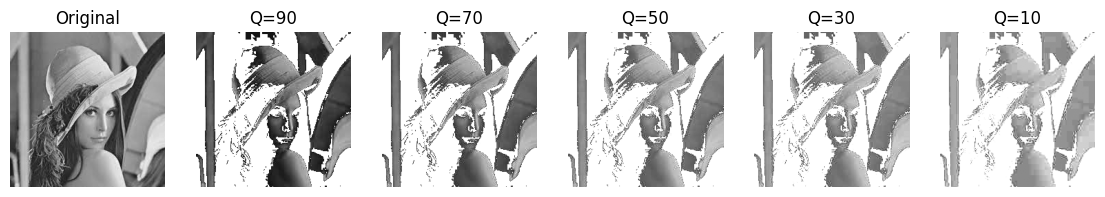

In [6]:
run_demo("test.jpg", quality_list=[90,70,50,30,10])
